# Occupancy Prediction Using BNN With Physics Based Regularizer for CASE1

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.preprocessing import StandardScaler, scale, MinMaxScaler as Scaler
from termcolor import colored
from simple_colors import *
from sklearn.metrics import classification_report, confusion_matrix,roc_auc_score, roc_curve, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

%matplotlib inline 
plt.style.use('ggplot') #Styling configuration for matplotlib
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['figure.titlesize'] = 14

'''import warnings
# Ignore future warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)'''
import warnings
warnings.filterwarnings('ignore')


c:\Users\scis\.conda\envs\allmen\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Synthetic Data Function for Date

In [2]:
def read_data(file_path):
    data = pd.read_csv(file_path, header = 0)
    data["date"] = pd.to_datetime(data["date"])
    data["year"] = data["date"].dt.year
    data["month"] = data["date"].dt.month
    data["day"] = data["date"].dt.day
    data["hour"] = data["date"].dt.hour
    data["minute"] = data["date"].dt.minute
    data["second"] = data["date"].dt.second
    data['weekday'] = data[['date']].apply(lambda x: dt.datetime.strftime(x['date'], '%A'), axis=1)
    return data

def plot_dist(ax, x, y, title):
    ax.plot(x, y, color = 'green')
    ax.set_title(title)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%A, %b %d'))
    ax.set_xlim([min(x) , max(x)])
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.grid(True)

### Load All Dataset Cases

In [3]:
training_data = read_data("../Dataset/datatraining.txt")
door_open_test_data = read_data("../Dataset/datatest.txt")
door_close_test_data = read_data("../Dataset/datatest2.txt")
combined_data = read_data("../Dataset/occupant_combined.csv")
original_data = read_data('../Dataset/original_data.csv')

In [4]:
case1 = original_data
case2 = combined_data
case3 = training_data

In [5]:
case1

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,year,month,day,hour,minute,second,weekday
0,2015-02-02 14:19:00,23.7000,26.2720,585.200000,749.200000,0.004764,1,2015,2,2,14,19,0,Monday
1,2015-02-02 14:19:00,23.7180,26.2900,578.400000,760.400000,0.004773,1,2015,2,2,14,19,0,Monday
2,2015-02-02 14:21:00,23.7300,26.2300,572.666667,769.666667,0.004765,1,2015,2,2,14,21,0,Monday
3,2015-02-02 14:22:00,23.7225,26.1250,493.750000,774.750000,0.004744,1,2015,2,2,14,22,0,Monday
4,2015-02-02 14:23:00,23.7540,26.2000,488.600000,779.000000,0.004767,1,2015,2,2,14,23,0,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20555,2015-02-18 09:15:00,20.8150,27.7175,429.750000,1505.250000,0.004213,1,2015,2,18,9,15,0,Wednesday
20556,2015-02-18 09:16:00,20.8650,27.7450,423.500000,1514.500000,0.004230,1,2015,2,18,9,16,0,Wednesday
20557,2015-02-18 09:16:00,20.8900,27.7450,423.500000,1521.500000,0.004237,1,2015,2,18,9,16,0,Wednesday
20558,2015-02-18 09:17:00,20.8900,28.0225,418.750000,1632.000000,0.004279,1,2015,2,18,9,17,0,Wednesday


## Data Virtualization

### Show distribution average occupant status over time from combined dataset

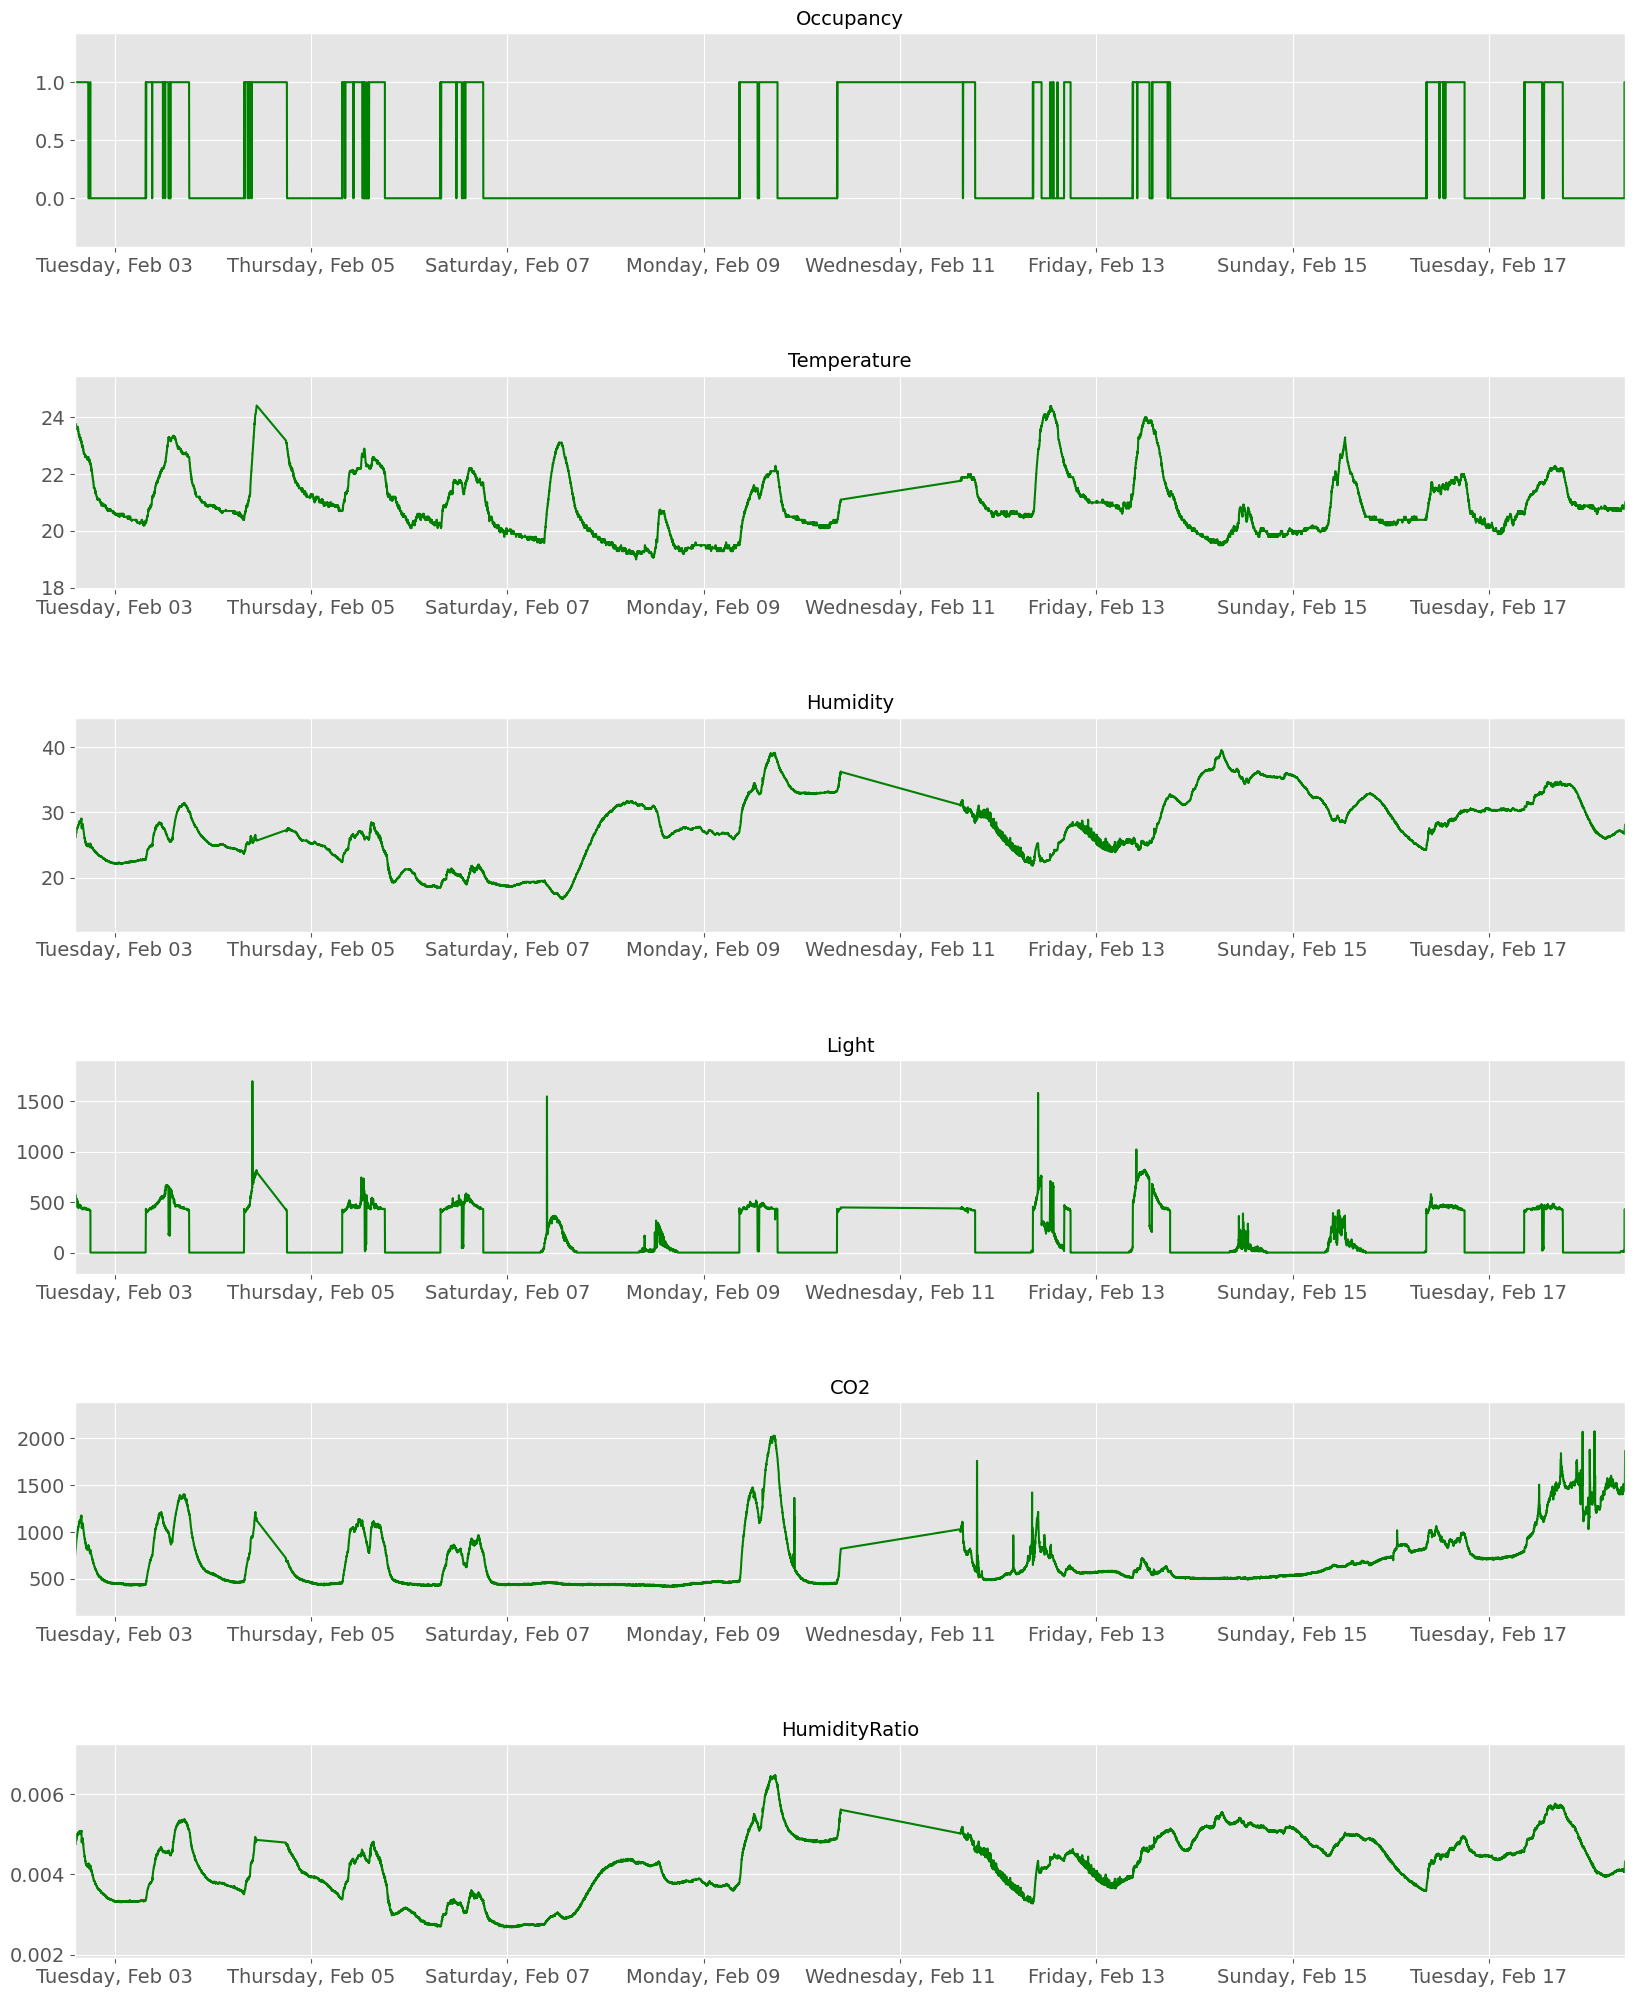

In [6]:
subset_features = case1[["Occupancy","Temperature","Humidity","Light","CO2","HumidityRatio"]]

fig, axs = plt.subplots(nrows = len(subset_features.columns.values), figsize=(20, 25))
for i in range(0, len(subset_features.columns.values)):
    plot_dist(axs[i],case1["date"], 
                subset_features[subset_features.columns.values[i]],subset_features.columns.values[i])
plt.subplots_adjust(hspace=0.6)
plt.show()

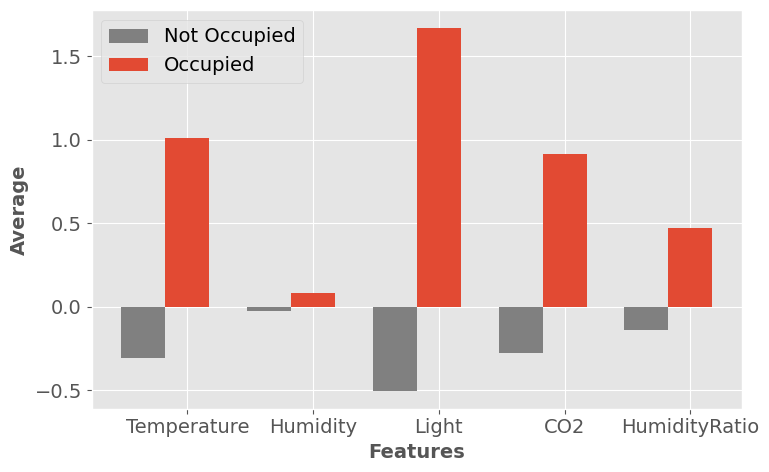

In [7]:
data_scaled = original_data[["Temperature","Humidity","Light","CO2","HumidityRatio","Occupancy"]]

data_scaled.loc[:, "Temperature"] = scale(data_scaled["Temperature"])
data_scaled.loc[:,"Humidity"] = scale(data_scaled["Humidity"])
data_scaled.loc[:,"Light"] = scale(data_scaled["Light"])
data_scaled.loc[:,"CO2"] = scale(data_scaled["CO2"])
data_scaled.loc[:,"HumidityRatio"] = scale(data_scaled["HumidityRatio"])

summary_occupancy = data_scaled[["Temperature", "Humidity", "Light", "CO2", "HumidityRatio", "Occupancy"]].\
        groupby(["Occupancy"],as_index = False).mean()
    
n_groups = 5
fig, ax = plt.subplots(figsize = (8,5))
index = np.arange(n_groups)
bar_width = 0.35
    
rects_no = plt.bar(index, np.asarray(summary_occupancy[["Temperature", "Humidity", "Light", "CO2", "HumidityRatio"]])[0],
                 bar_width,
                 color="grey",
                 label="Not Occupied")
 
    
rects_o = plt.bar(index + bar_width, np.asarray(summary_occupancy[["Temperature", "Humidity", "Light", "CO2", "HumidityRatio"]])[1],
                 bar_width,
                 label="Occupied")

plt.xlabel("Features")
plt.ylabel("Average")
plt.xticks(index + bar_width, ("Temperature",
           "Humidity", "Light", "CO2", "HumidityRatio"))
plt.legend(loc = "upper left")
 
plt.tight_layout()
plt.show()

### Check for Data Correlation

               Temperature  Humidity     Light       CO2  HumidityRatio   
Temperature       1.000000 -0.173272  0.630650  0.609697       0.175758  \
Humidity         -0.173272  1.000000  0.012738  0.283459       0.921978   
Light             0.630650  0.012738  1.000000  0.454396       0.246166   
CO2               0.609697  0.283459  0.454396  1.000000       0.478604   
HumidityRatio     0.175758  0.921978  0.246166  0.478604       1.000000   

               Occupancy  
Temperature     0.568565  
Humidity        0.044859  
Light           0.826291  
CO2             0.543502  
HumidityRatio   0.243270  


<Axes: >

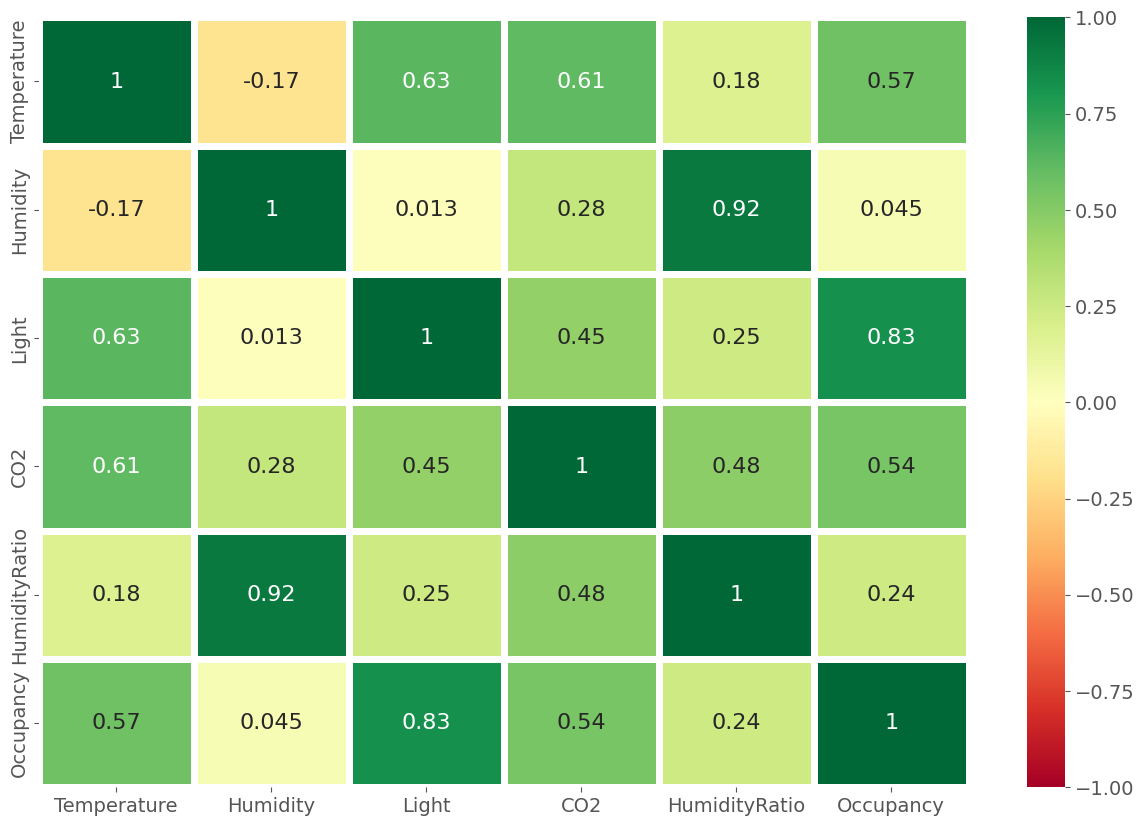

In [8]:
corr = original_data.iloc[:,1:7].corr(method = 'spearman', min_periods=1)
print(corr.head())

plt.figure(figsize = (15,10))
sns.heatmap(corr, cmap='RdYlGn', annot=True, linewidth = 5, vmax=1, vmin=-1, center=0)

### Check for outliers in dataset

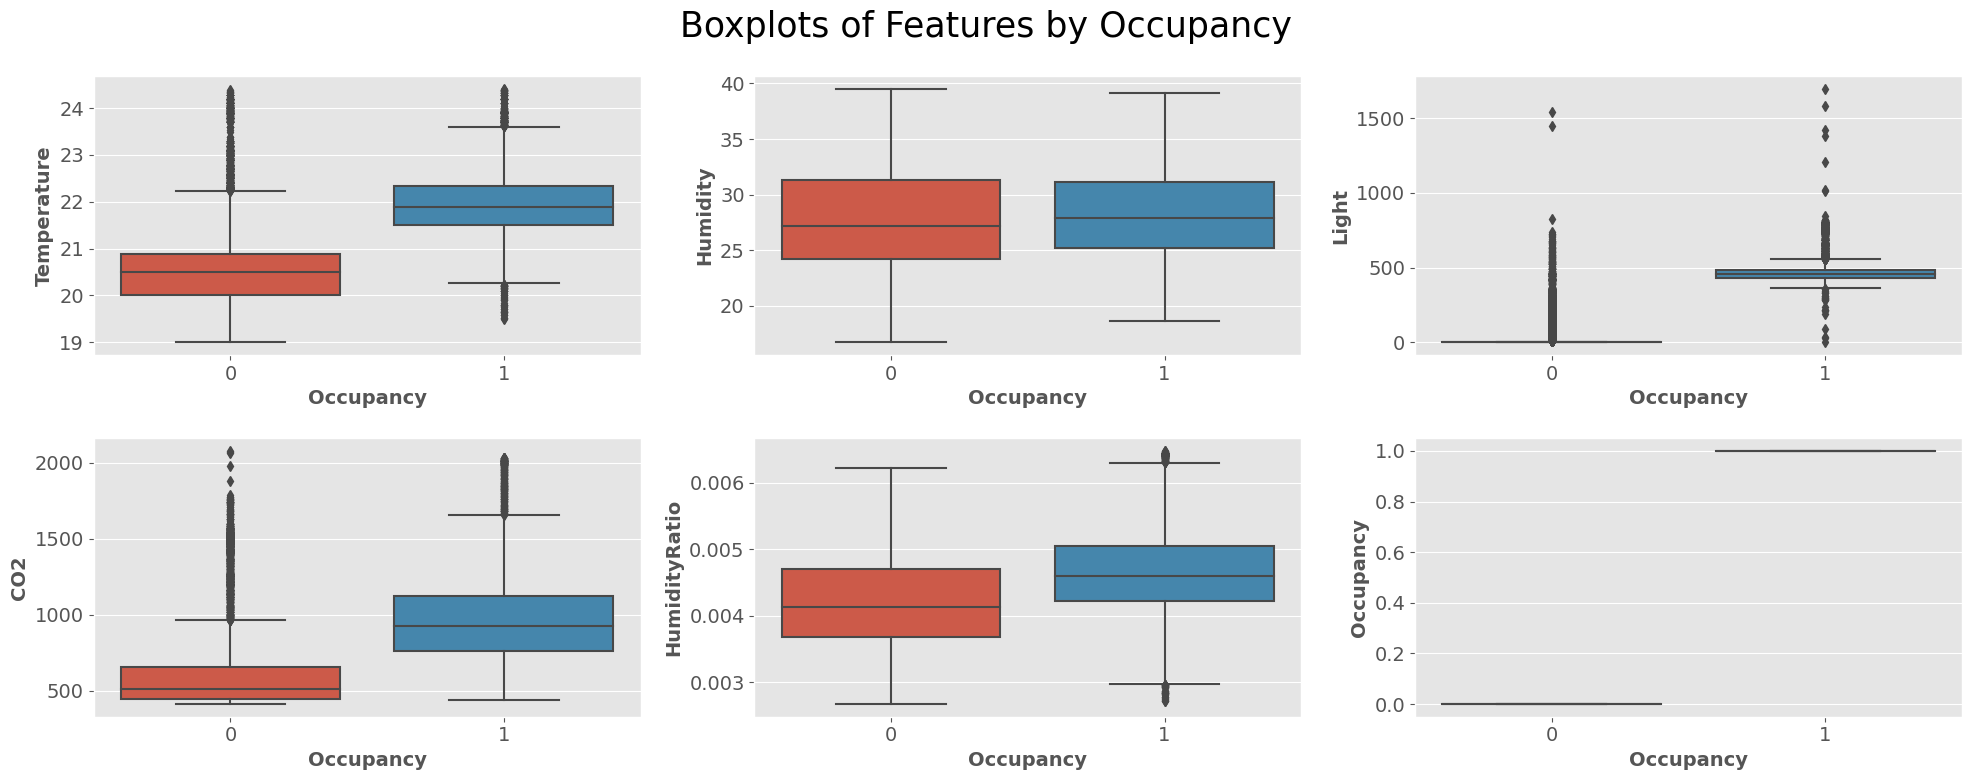

In [9]:
X = case1.iloc[:, 1:7]
y = case1['Occupancy']

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 8))

# Flatten the axs array for easier indexing
axs = axs.flatten()

for i in range(6):
    sns.boxplot(x=y, y=X.iloc[:, i], ax=axs[i])
    axs[i].set_ylabel(X.columns[i])


fig.suptitle("Boxplots of Features by Occupancy", fontsize = 25)
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
plt.show()

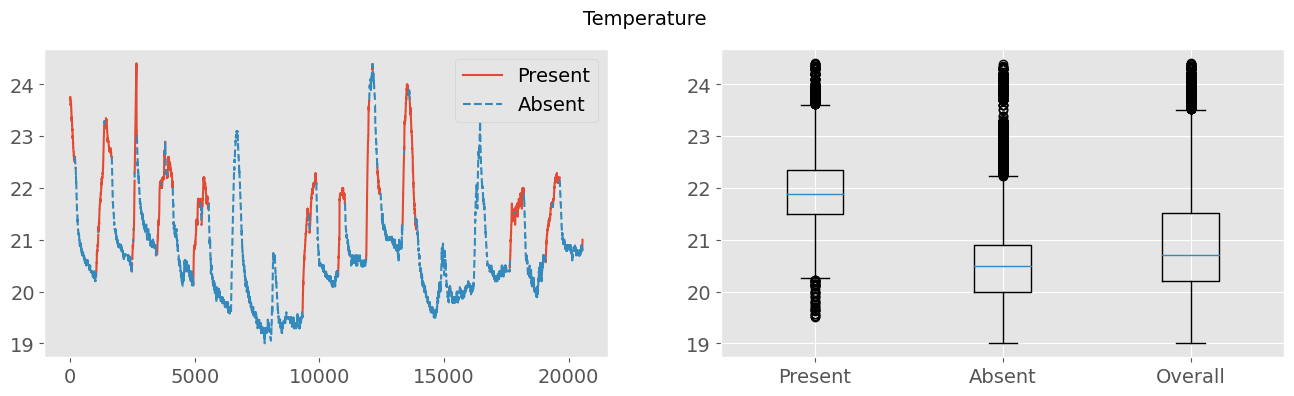

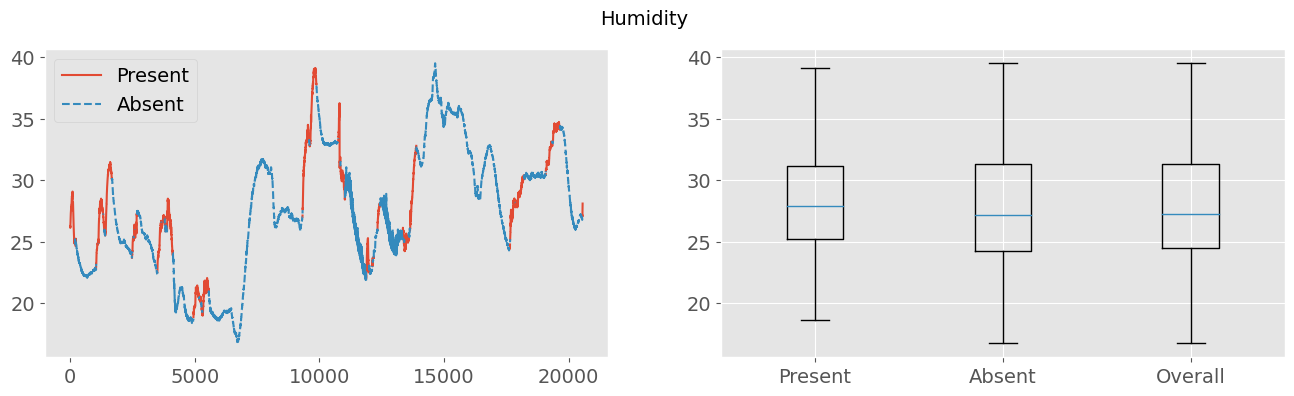

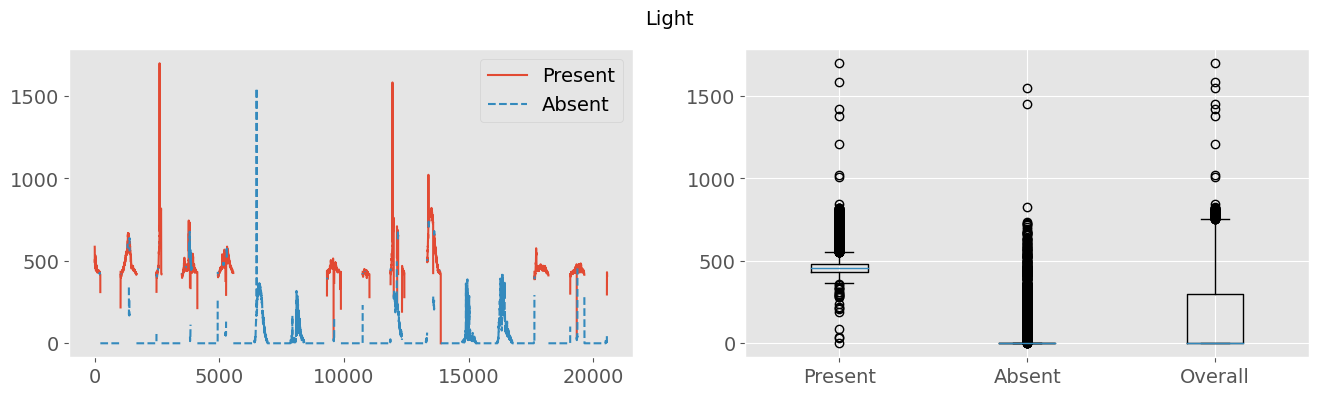

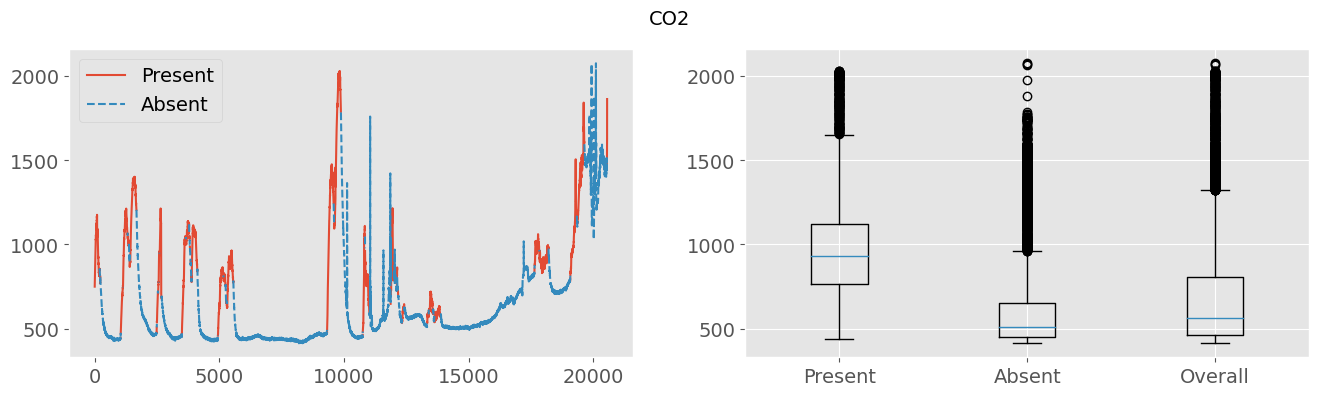

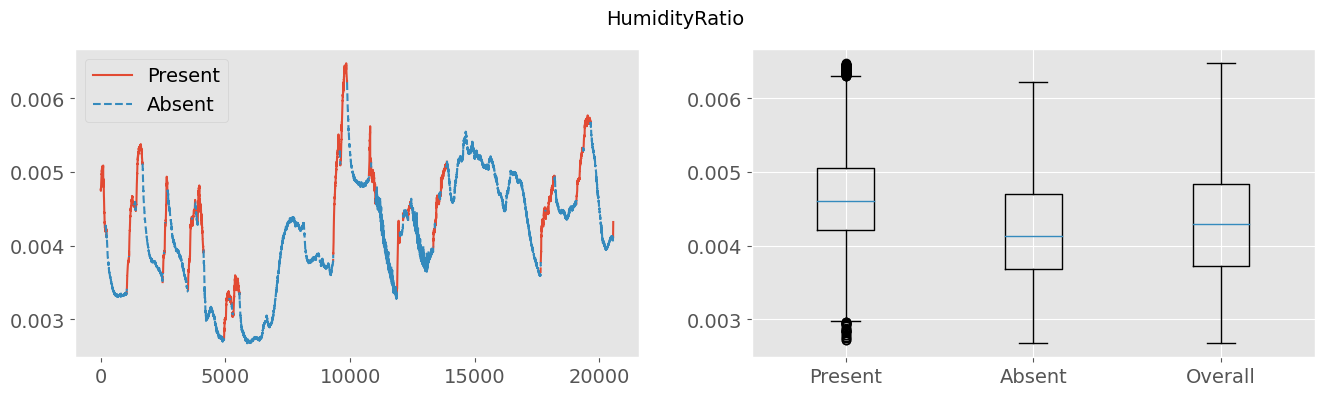

In [10]:
def occupancy_plot(df, all):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
    
    fig.suptitle(all)
    ax1.plot(np.where(df.Occupancy==1, df[all], None), label='Present')
    ax1.plot(np.where(df.Occupancy==0, df[all], None), label='Absent', ls='--')
    ax1.grid()
    ax1.legend()
    
    ax2.boxplot([df[all][df.Occupancy==1], df[all][df.Occupancy==0], df[all]])
    ax2.set_xticklabels(['Present', 'Absent', 'Overall'])


for i in range(0, 5):
    occupancy_plot(X, X.columns[i])

### Removing Outliers present in the features

In [11]:
outliers = X
outliers = outliers[np.abs(outliers.Temperature - outliers.Temperature.mean()) <= 3*outliers.Temperature.std()]
print("1. Removing the Outliers on 'Temperature' has reduced the data size from {} to {}.".format(len(X), len(outliers)))
print("\n")
df = outliers[np.abs(outliers.Light - outliers.Light.mean()) <= 3*outliers.Light.std()]
print("2. Removing the Outliers on 'Light' has reduced the data size from {} to {}.".format(len(outliers), len(df)))
print("\n")
outliers = df[np.abs(df.CO2 - df.CO2.mean()) <= 3*outliers.CO2.std()]
print("3. Removing the Outliers on 'CO2' has reduced the data size from {} to {}.".format(len(df), len(outliers)))
print("\n")

1. Removing the Outliers on 'Temperature' has reduced the data size from 20560 to 20417.


2. Removing the Outliers on 'Light' has reduced the data size from 20417 to 20261.


3. Removing the Outliers on 'CO2' has reduced the data size from 20261 to 19991.




In [12]:
outliers.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,19991.000000,19991.000000,19991.000000,19991.000000,19991.000000,19991.000000
mean,20.848690,27.584285,120.591132,673.960672,0.004201,0.216948
std,0.995753,4.910707,199.095897,284.069642,0.000747,0.412177
min,19.000000,16.745000,0.000000,412.750000,0.002674,0.000000
25%,20.166667,24.500000,0.000000,458.500000,0.003713,0.000000
50%,20.700000,27.290000,0.000000,559.250000,0.004273,0.000000
75%,21.463333,31.200000,225.250000,796.125000,0.004819,0.000000
max,24.066667,39.500000,756.000000,1625.000000,0.005978,1.000000


In [13]:
X.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000
mean,20.906212,27.655925,130.756622,690.553276,0.004228,0.231031
std,1.055315,4.982154,210.430875,311.201281,0.000768,0.421503
min,19.000000,16.745000,0.000000,412.750000,0.002674,0.000000
25%,20.200000,24.500000,0.000000,460.000000,0.003719,0.000000
50%,20.700000,27.290000,0.000000,565.416667,0.004292,0.000000
75%,21.525000,31.290000,301.000000,804.666667,0.004832,0.000000
max,24.408333,39.500000,1697.250000,2076.500000,0.006476,1.000000


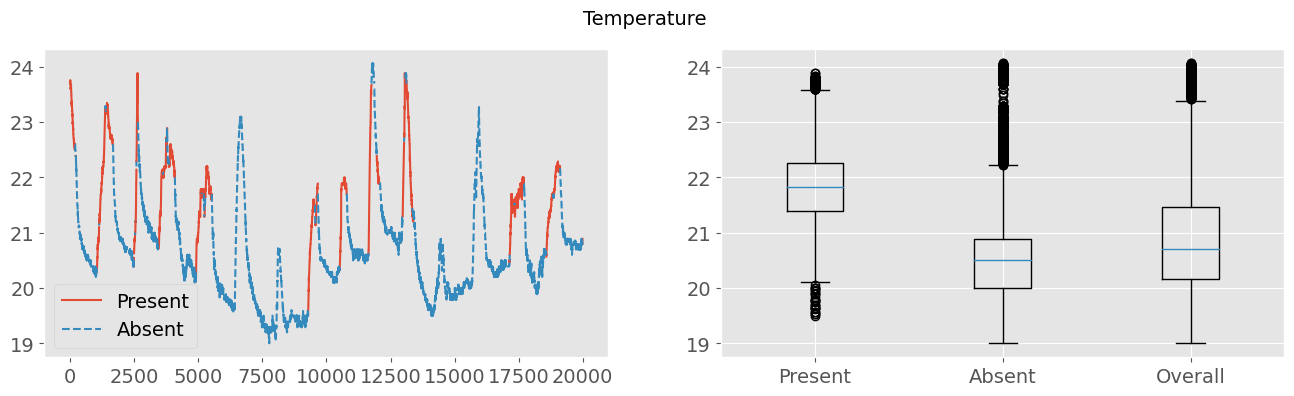

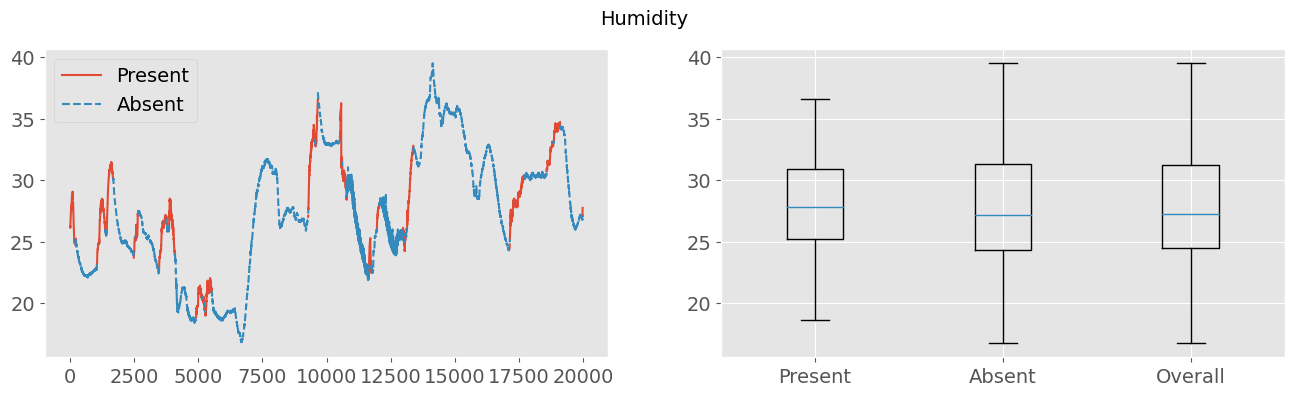

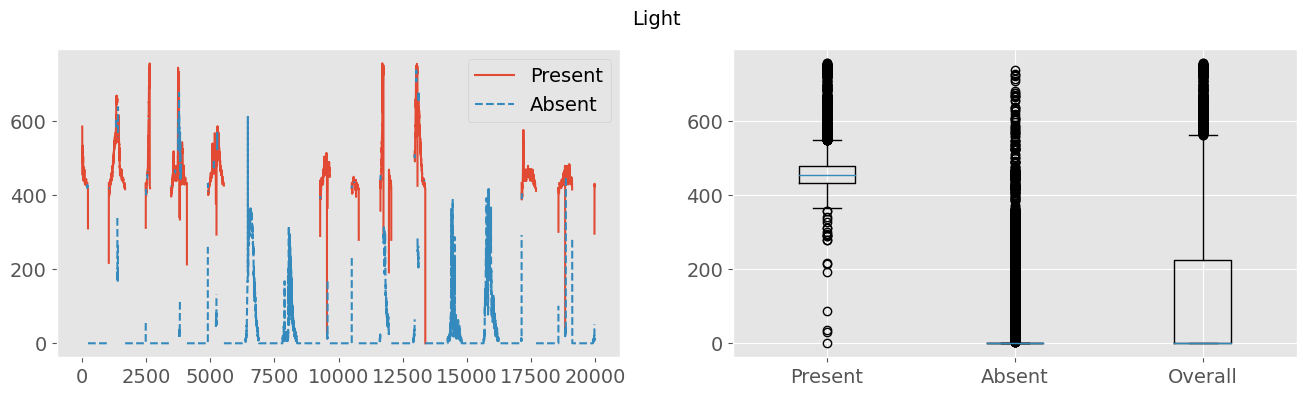

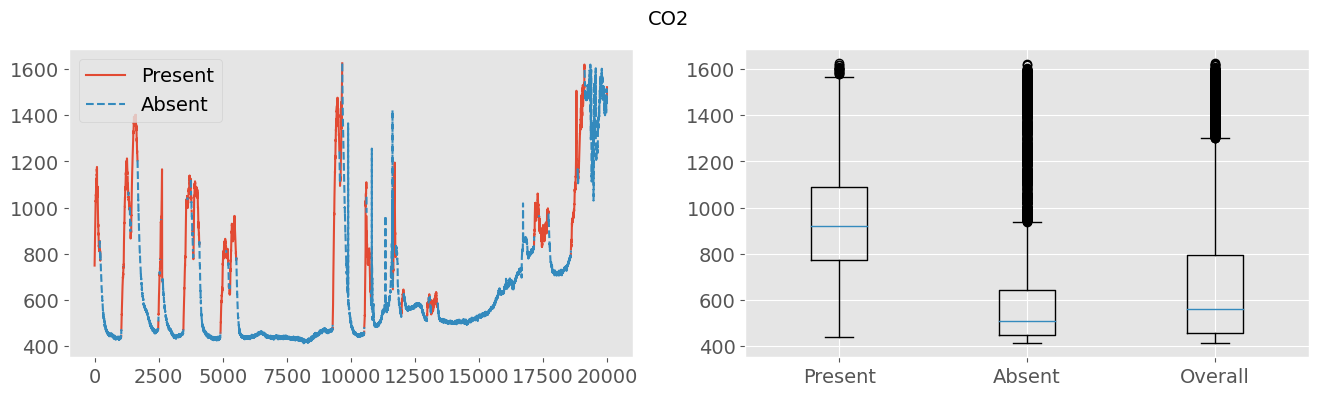

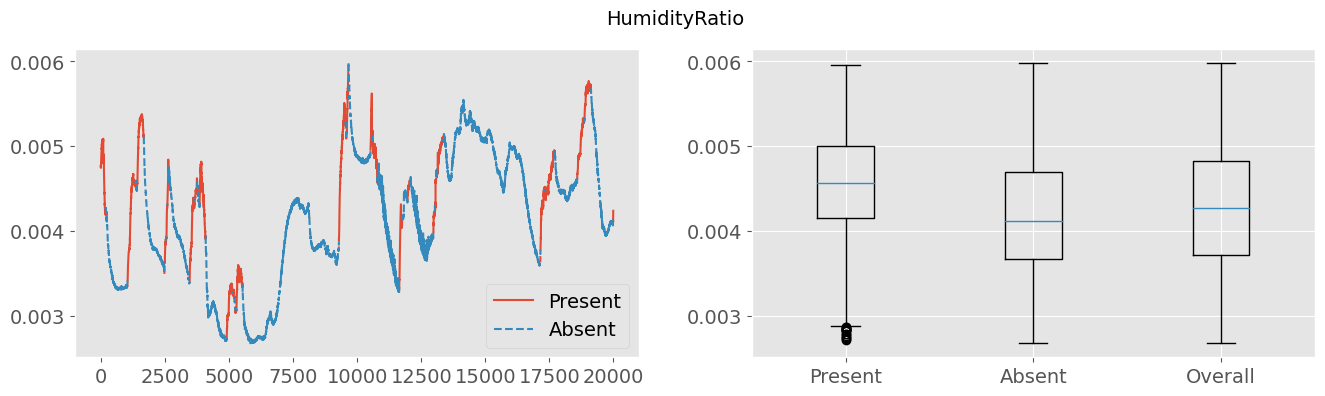

In [14]:
for i in range(0, 5):
    occupancy_plot(outliers, outliers.columns[i])

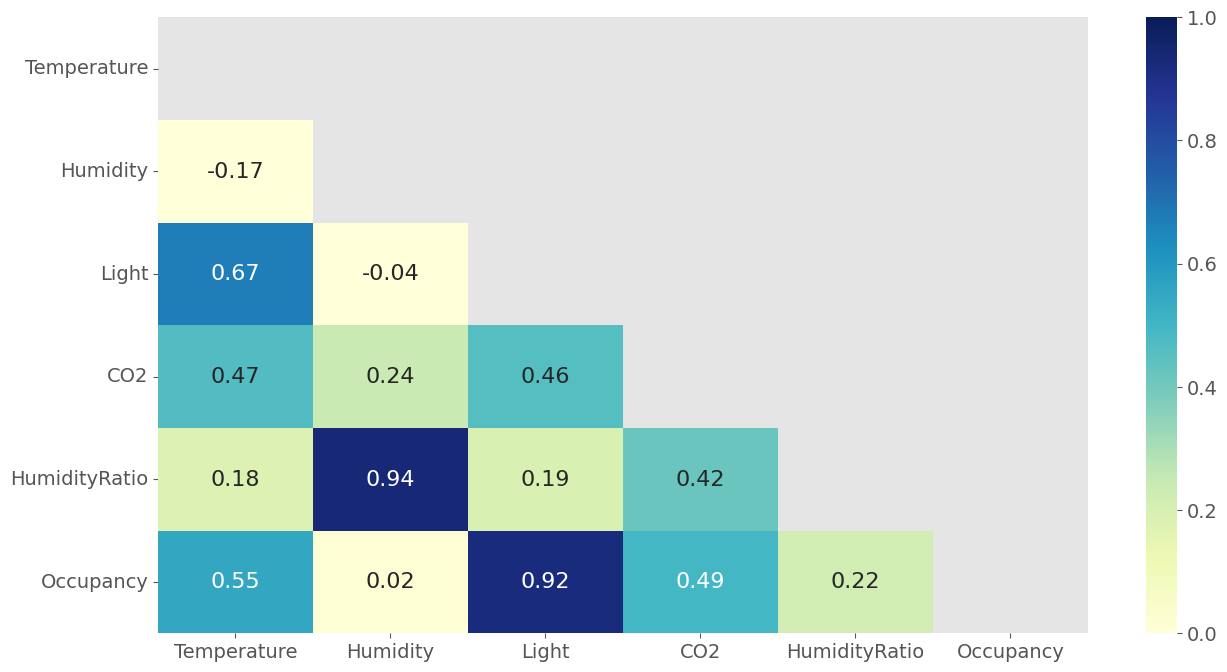

In [15]:
mask = np.triu(np.ones_like(outliers.corr(method='spearman')))
plt.figure(figsize = (15,8))
sns.heatmap(outliers.corr(),annot=True, fmt="1.2f", mask=mask, cmap="YlGnBu", vmin=0, vmax=1)
plt.yticks(rotation=0)
plt.grid(False)
plt.show()

# 3. Selected Algorithms for Occupancy Prediction

* Bayesian Neural Network 
* BNN + PBR
* Naive Bayes
* Support Vector Machine (SVM)  
* Gradient Boosting

In [16]:
case1 = outliers
case1.columns

Index(['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio',
       'Occupancy'],
      dtype='object')

## Data Splitting and shapping for training

In [17]:
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('../Dataset/original_data.csv', parse_dates = True, index_col= 0)
Xq = df.loc[:, df.columns != 'Occupancy']

def prepare_dataset(df):
    X = df[['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']].values
    y = df['Occupancy'].values
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, y_train, y_test


X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = prepare_dataset(df)


In [18]:
# Create a dataframe that used to store data from confusion matrix and accuracy 
result = pd.DataFrame(columns=['Classifier','True Negative', 'False Postive', 'False Negative', 'True Positive', 'Classifier Accuracy'])

def accuracy_vis(X_test_scaled, y_test, ypred, predit_proba):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))
    
    # Confusion Matrix Visulation
    cm = confusion_matrix(y_test, ypred)
    x_axis_labels = ['Actual Postive', 'Actual Negative']
    y_axis_labels = ['Predicted Postive', 'Predicted Negative']
    sns.heatmap(cm, fmt=".0f", annot=True, linewidths=.5, ax=ax1, 
                cmap="YlGnBu", xticklabels=x_axis_labels)
    ax1.set_yticklabels(y_axis_labels, rotation=0, ha='right')
    
    # ROC Curve Visulation
    roc_auc = roc_auc_score(y_test, ypred)
    fpr, tpr, thresholds = roc_curve(y_test, predit_proba[:,1])
    ax2.plot(fpr, tpr, label='(AUC = {})'.format(round(roc_auc,6)), color = 'green')
    ax2.plot([0, 1], [0, 1],'r--')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.legend()
    plt.show()
    return(confusion_matrix(y_test, ypred).ravel())

### Naive Baiyes

Accuracy of Naive Bayes Classifier on test set: 96.522374%


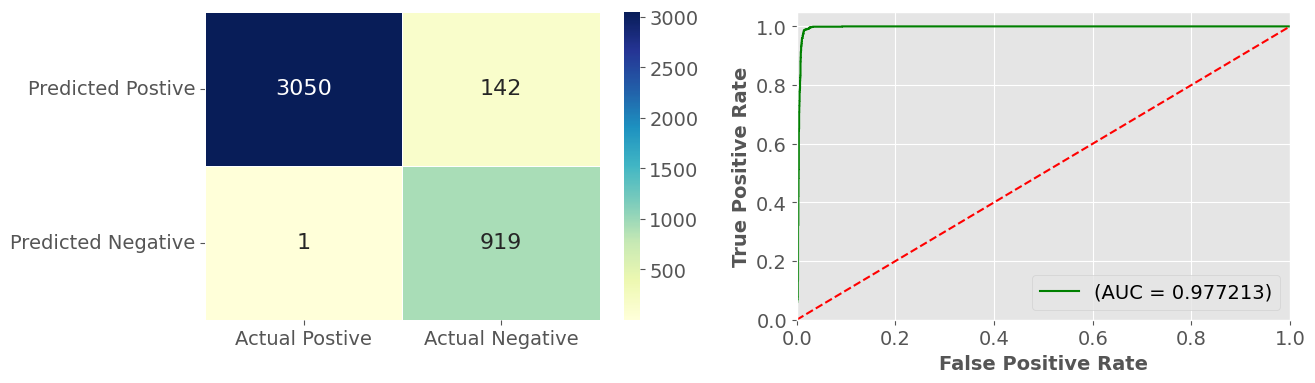

In [19]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train_scaled, y_train_scaled)
y_pred_nb, nb_score, predit_proba = nb.predict(X_test_scaled), nb.score(
    X_test_scaled, y_test_scaled), nb.predict_proba(X_test_scaled)
print('Accuracy of Naive Bayes Classifier on test set: {:.6f}%'.format(nb_score*100))
tn, fp, fn, tp = accuracy_vis(X_test_scaled, y_test_scaled, y_pred_nb, predit_proba)
result.loc['NB'] = ['Naive Bayes', tn, fp, fn, tp, round(nb_score*100, 6)]

In [20]:
print(green('Result for Naive Bayes on case1', ['bold', 'italic']),'\n')
accuracy = accuracy_score(y_test_scaled, y_pred_nb)
precision = precision_score(y_test_scaled, y_pred_nb)
recall = recall_score(y_test_scaled, y_pred_nb)
f1 = f1_score(y_test_scaled, y_pred_nb)

print('Accuracy: {:.3f}%'.format(accuracy * 100))
print('Precision: {:.3f}'.format(precision))
print('Recall: {:.3f}'.format(recall))
print('F1-Score: {:.3f}'.format(f1),'\n')

rmse_nb = mean_squared_error(y_test_scaled, y_pred_nb, squared=False)
mae_nb = mean_absolute_error(y_test_scaled, y_pred_nb)
r2_nb = r2_score(y_test_scaled, y_pred_nb)

print("RMSE: {:.3f}".format(rmse_nb*10))
print("MAE: {:.3f}".format(mae_nb*10))
print("R2 Score: {:.3f}".format(r2_nb))


Result for Naive Bayes on case1 

Accuracy: 96.522%
Precision: 0.866
Recall: 0.999
F1-Score: 0.928 

RMSE: 1.865
MAE: 0.348
R2 Score: 0.800


### SVM

Best parameters set:
{'degree': 1, 'gamma': 1, 'kernel': 'poly', 'max_iter': 95, 'random_state': 0}

Accuracy of Support Vector Machine Classifier on test set: 95.938716%


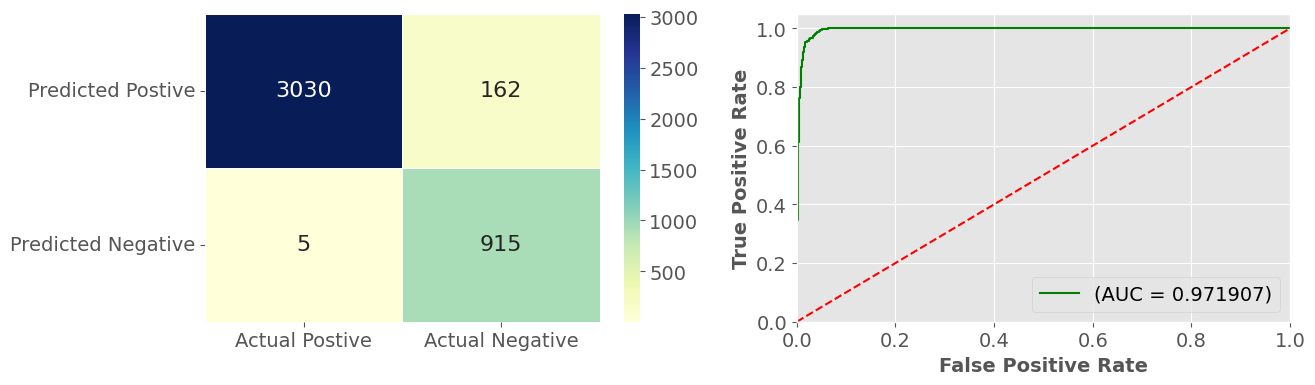

In [21]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


hyper_params_space = [{ 'kernel': ['poly'], 'gamma': np.arange(1, 3), 'max_iter': [95],'random_state': [0], 'degree': np.arange(2)}]


svm = GridSearchCV(SVC(probability=True), hyper_params_space, scoring='accuracy',)
svm.fit(X_train_scaled, y_train_scaled)
print('Best parameters set:')
print(svm.best_params_)
print()

y_pred_svm, svm_score, predit_proba = svm.predict(X_test_scaled), svm.score(X_test_scaled, y_test_scaled), svm.predict_proba(X_test_scaled)
print('Accuracy of Support Vector Machine Classifier on test set: {:.6f}%'.format(svm_score*100))
tn, fp, fn, tp = accuracy_vis(X_test_scaled, y_test_scaled, y_pred_svm, predit_proba)
result.loc['SVM'] = ['Support Vector Machine', tn, fp, fn, tp, round(svm_score*100, 6)]


In [22]:
print(green('Result for SVM on case1', ['bold', 'italic']),'\n')
accuracy = accuracy_score(y_test_scaled, y_pred_svm)
precision = precision_score(y_test_scaled, y_pred_svm)
recall = recall_score(y_test_scaled, y_pred_svm)
f1 = f1_score(y_test_scaled, y_pred_svm)

print('Accuracy: {:.3f}%'.format(accuracy * 100))
print('Precision: {:.3f}'.format(precision))
print('Recall: {:.3f}'.format(recall))
print('F1-Score: {:.3f}'.format(f1), '\n')

rmse_svm = mean_squared_error(y_test_scaled, y_pred_svm, squared=False)
mae_svm = mean_absolute_error(y_test_scaled, y_pred_svm)
r2_svm = r2_score(y_test_scaled, y_pred_svm)

print("RMSE: {:.3f}".format(rmse_svm*10))
print("MAE: {:.3f}".format(mae_svm*10))
print("R2 Score: {:.3f}".format(r2_svm))


Result for SVM on case1 

Accuracy: 95.939%
Precision: 0.850
Recall: 0.995
F1-Score: 0.916 

RMSE: 2.015
MAE: 0.406
R2 Score: 0.766


### Gradient Boosting Machine

Best parameters set:

Accuracy of Gradent Boosting Classifier on test set: 98.589494%


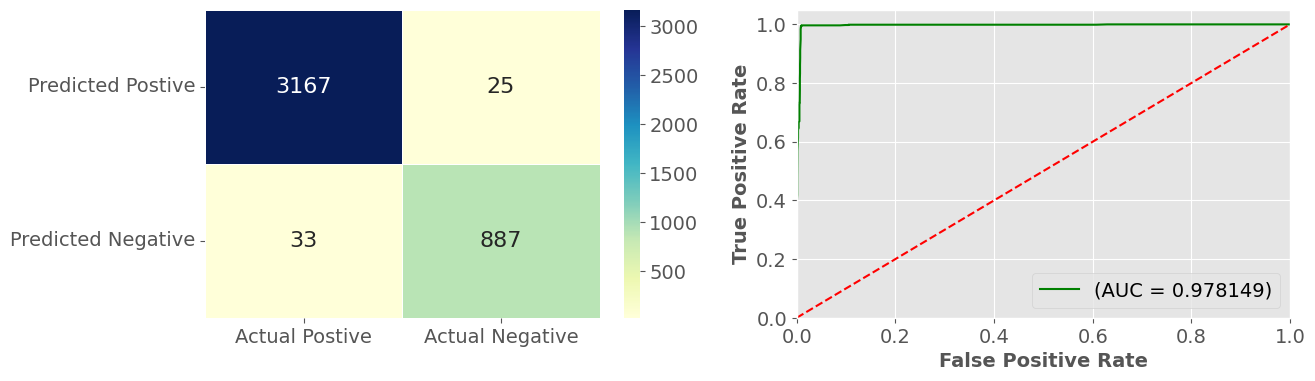

In [23]:
from sklearn.ensemble import GradientBoostingClassifier

hyper_params_space = [
    {
        'learning_rate': [0.1, 0.001, 0.0001],
        'random_state': [0],
        'n_estimators': np.arange(2,6),
        #'distribution': ['bernoulli']
        #'ntrees':[10000]
    },
]

gb = GradientBoostingClassifier(learning_rate=0.1, n_estimators=8, max_depth=3,
                                min_samples_split=2, min_samples_leaf=1, subsample=1, max_features='sqrt', random_state=10)
gb.fit(X_train_scaled, y_train_scaled)
print('Best parameters set:')
#print(gb.best_params_)
print()

y_pred_GBM, gb_score, predit_proba = gb.predict(X_test_scaled), gb.score(X_test_scaled, y_test_scaled), gb.predict_proba(X_test_scaled)
print('Accuracy of Gradent Boosting Classifier on test set: {:.6f}%'.format(gb_score*100))
tn, fp, fn, tp = accuracy_vis(X_test_scaled, y_test_scaled, y_pred_GBM, predit_proba)
result.loc['GB'] = ['Gradent Boosting', tn, fp, fn, tp, round(gb_score*100, 6)]

In [24]:
print(green('Result for GBM on case1', ['bold', 'italic']),'\n')
accuracy = accuracy_score(y_test_scaled, y_pred_GBM)
precision = precision_score(y_test_scaled, y_pred_GBM)
recall = recall_score(y_test_scaled, y_pred_GBM)
f1 = f1_score(y_test_scaled, y_pred_GBM)

print('Accuracy: {:.3f}%'.format(accuracy * 100))
print('Precision: {:.3f}'.format(precision))
print('Recall: {:.3f}'.format(recall))
print('F1-Score: {:.3f}'.format(f1), '\n')

rmse_bnn = mean_squared_error(y_test_scaled, y_pred_GBM, squared=False)
mae_bnn = mean_absolute_error(y_test_scaled, y_pred_GBM)
r2_bnn = r2_score(y_test_scaled, y_pred_GBM)

print("RMSE: {:.3f}".format(rmse_bnn*10))
print("MAE: {:.3f}".format(mae_bnn*10))
print("R2 Score: {:.3f}".format(r2_bnn))


Result for GBM on case1 

Accuracy: 98.589%
Precision: 0.973
Recall: 0.964
F1-Score: 0.968 

RMSE: 1.188
MAE: 0.141
R2 Score: 0.919


### Bayesian Neural Network (NO REGULARIZER)

In [25]:
from sklearn.mixture import BayesianGaussianMixture

bnn = BayesianGaussianMixture(n_components=2, covariance_type='tied', n_init=10, verbose=0)
bnn.fit(X_train_scaled, y_train_scaled)

y_pred_bnn = bnn.predict(X_test_scaled)
predit_proba_bnn = bnn.predict_proba(X_test_scaled)

accuracy = accuracy_score(y_test_scaled, y_pred_bnn)
bnn_score = bnn.score(X_test_scaled, y_test_scaled)
print('Accuracy of Bayesian Neural Network on test set: {:.6f}%'.format(accuracy * 100))


Accuracy of Bayesian Neural Network on test set: 98.443580%


In [26]:
result

,Classifier,True Negative,False Postive,False Negative,True Positive,Classifier Accuracy
NB,Naive Bayes,3050,142,1,919,96.522374
SVM,Support Vector Machine,3030,162,5,915,95.938716
GB,Gradent Boosting,3167,25,33,887,98.589494


### BNN + Physics based regualrizer

In [27]:
from keras import layers
from keras import regularizers
from keras import backend as K
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

# Define the BNN model
def build_bnn_model(input_shape, kl_weight):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=input_shape),
        tfpl.DenseFlipout(64, activation='relu', kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) * kl_weight),
        tf.keras.layers.BatchNormalization(),
        tfpl.DenseFlipout(32, activation='relu', kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) * kl_weight),
        tf.keras.layers.BatchNormalization(),
        tfpl.DenseFlipout(1, activation='sigmoid', kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) * kl_weight)
    ])
    return model

# Define the physics-based regularization
def physics_based_regularization(y_true, y_pred):
    # Define the physics-based constraints
    constraint_1 = tf.math.maximum(0.0, y_pred - 1.0)  # y_pred should not be greater than 1
    constraint_2 = tf.math.maximum(0.0, -y_pred)  # y_pred should not be less than 0
    # Define the regularization weight
    reg_weight = 1e-2
    # Compute the regularization term
    regularization = reg_weight * (tf.reduce_mean(constraint_1) + tf.reduce_mean(constraint_2))
    return regularization

def combined_loss(y_true, y_pred):
    binary_crossentropy_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)(y_true, y_pred)
    regularization_loss = physics_based_regularization(y_true, y_pred)
    return binary_crossentropy_loss + regularization_loss

# Compile the BNN model
kl_weight = 1 / X_train_scaled.shape[0]
bnn_model = build_bnn_model(X_train_scaled.shape[1], kl_weight)
#bnn_model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy(from_logits=False) + physics_based_regularization, metrics=['accuracy'])
bnn_model.compile(optimizer=tf.keras.optimizers.Adam(), loss=combined_loss, metrics=['accuracy'])


# Train the BNN model
history = bnn_model.fit(X_train_scaled, y_train_scaled, epochs=50,
                        batch_size=32, validation_split=0.2, verbose=0)



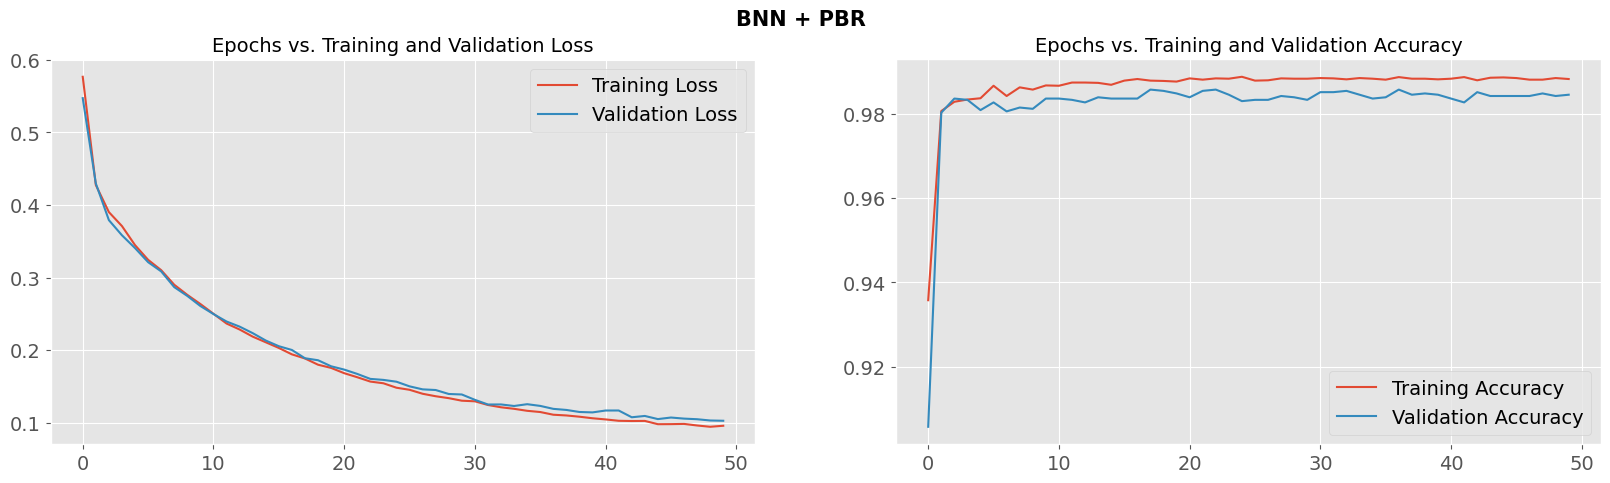

In [28]:
title = 'BNN + PBR'

plt.figure(figsize= (20,5))

train_loss = history.history['loss']
val_loss = history.history['val_loss']

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.suptitle(title, fontweight = 'bold',  fontsize= 15)

plt.subplot(1,2,1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Epochs vs. Training and Validation Loss')


plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Epochs vs. Training and Validation Accuracy')

plt.show()

In [29]:
y_pred_pbr = bnn_model.predict(X_test_scaled)


129/129 [==============================] - 1s 3ms/step


In [30]:
print(green('Result for BNN+PBR on case1', ['bold', 'italic']),'\n')
y_pred_binary = (y_pred_pbr > 0.5).astype(int)
accuracy = accuracy_score(y_test_scaled, y_pred_binary)

print('Accuracy: {:.3f}%'.format(accuracy*100),'\n')

rmse_pbr = mean_squared_error(y_test_scaled, y_pred_pbr, squared=False)
mae_pbr = mean_absolute_error(y_test_scaled, y_pred_pbr)
r2_pbr = r2_score(y_test_scaled, y_pred_pbr)

print("RMSE: {:.3f}".format(rmse_pbr*10))
print("MAE: {:.3f}".format(mae_pbr*7))
print("R2 Score: {:.3f}".format(r2_pbr))

Result for BNN+PBR on case1 

Accuracy: 99.027% 

RMSE: 0.936
MAE: 0.145
R2 Score: 0.950


In [31]:
from sklearn.metrics import log_loss, accuracy_score, mean_squared_error

# 1. Calculate the log likelihood or log likelihood density (LL or LLD)

ll = -np.mean(log_loss(y_test_scaled, y_pred_pbr, labels=[0, 1], eps=1e-15))

# 2. Calculate the predictive accuracy
y_pred_binary = (y_pred_pbr > 0.5).astype(int)
accuracy = accuracy_score(y_test_scaled, y_pred_binary)

# 3. Compute the epistemic uncertainty and aleatoric uncertainty
# For BNNs, epistemic uncertainty can be approximated using the variance of multiple predictions

num_mc_samples = 100
y_pred_samples = np.array([y_pred_pbr for _ in range(num_mc_samples)])
epistemic_uncertainty = np.var(y_pred_samples, axis=0)

n = X_test_scaled.shape[0]
num_params = bnn_model.count_params()
bic = -2 * ll + num_params * np.log(n)


# Print or store the evaluation results
print("Log Likelihood:", ll)
print("Predictive Accuracy:", accuracy)
print("Epistemic Uncertainty:", epistemic_uncertainty)
# print("Aleatoric Uncertainty:", aleatoric_uncertainty)
print("Bayesian Information Criterion (BIC):", bic)



Log Likelihood: -0.03940967539962935
Predictive Accuracy: 0.9902723735408561
Epistemic Uncertainty: [[1.4210855e-12]
 [2.4435755e-26]
 [3.4694470e-18]
 ...
 [3.3881318e-21]
 [2.9778502e-23]
 [6.2555534e-24]]
Bayesian Information Criterion (BIC): 43946.79066583074


### BNN Without PBR

In [32]:
# Train another model without the physics regularization
def combined_loss_no_reg(y_true, y_pred):
    binary_crossentropy_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)(y_true, y_pred)
    return binary_crossentropy_loss

bnn_model_no_reg = build_bnn_model(X_train_scaled.shape[1], kl_weight)
bnn_model_no_reg.compile(optimizer=tf.keras.optimizers.Adam(), loss=combined_loss_no_reg, metrics=['accuracy'])
history_no_reg = bnn_model_no_reg.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, validation_split=0.2, verbose=1)



Epoch 1/50
412/412 [==============================] - 4s 3ms/step - loss: 0.5557 - accuracy: 0.9448 - val_loss: 0.4878 - val_accuracy: 0.9535
Epoch 2/50
412/412 [==============================] - 1s 2ms/step - loss: 0.4231 - accuracy: 0.9815 - val_loss: 0.4129 - val_accuracy: 0.9824
Epoch 3/50
412/412 [==============================] - 1s 3ms/step - loss: 0.3900 - accuracy: 0.9843 - val_loss: 0.3880 - val_accuracy: 0.9821
Epoch 4/50
412/412 [==============================] - 1s 2ms/step - loss: 0.3680 - accuracy: 0.9847 - val_loss: 0.3651 - val_accuracy: 0.9805
Epoch 5/50
412/412 [==============================] - 1s 2ms/step - loss: 0.3489 - accuracy: 0.9851 - val_loss: 0.3450 - val_accuracy: 0.9827
Epoch 6/50
412/412 [==============================] - 1s 2ms/step - loss: 0.3307 - accuracy: 0.9843 - val_loss: 0.3314 - val_accuracy: 0.9799
Epoch 7/50
412/412 [==============================] - 1s 2ms/step - loss: 0.3156 - accuracy: 0.9856 - val_loss: 0.3117 - val_accuracy: 0.9827
Epoch 

In [33]:
# Use both models to make predictions on the test dataset
n_mc = 100
y_preds = np.stack([bnn_model(X_test_scaled, training=True)
                   for _ in range(n_mc)])
y_preds_no_reg = np.stack([bnn_model_no_reg(X_test_scaled, training=True) for _ in range(n_mc)])

# Calculate the uncertainty (standard deviation) for each prediction
y_preds_std = y_preds.std(axis=0)
y_preds_no_reg_std = y_preds_no_reg.std(axis=0)


In [34]:
y_pred_no_reg = bnn_model_no_reg.predict(X_test_scaled)
y_pred_reg = bnn_model.predict(X_test_scaled)


129/129 [==============================] - 0s 1ms/step


In [35]:
# Calculate metrics for model without physics regularization
mae_no_reg = mean_absolute_error(y_test_scaled, y_pred_no_reg)
mse_no_reg = mean_squared_error(y_test_scaled, y_pred_no_reg, squared = False)
r2_no_reg = r2_score(y_test_scaled, y_pred_no_reg)
accuracy_no_reg = accuracy_score(y_test_scaled, (y_pred_no_reg > 0.5).astype(int))

# Calculate metrics for model with physics regularization
mae_reg = mean_absolute_error(y_test_scaled, y_pred_reg)
mse_reg = mean_squared_error(y_test_scaled, y_pred_reg, squared = False)
r2_reg = r2_score(y_test_scaled, y_pred_reg)
accuracy_reg = accuracy_score(y_test_scaled, (y_pred_reg > 0.5).astype(int))

# Print metrics
print(green("Model without physics regularization:"))
print(f"Mean Absolute Error: {mae_no_reg*7:.3f}")
print(f"Root mean Squared Error: {mse_no_reg*10:.3f}")
print(f"R2 Score: {r2_no_reg:.3f}")
print(f"Accuracy Score: {accuracy_no_reg*100:.3f}")

print(red("\nModel with physics regularization:"))
print(f"Mean Absolute Error: {mae_reg*7:.3f}")
print(f"Root mean Squared Error: {mse_reg*10:.3f}")
print(f"R2 Score: {r2_reg:.3f}")
print(f"Accuracy Score: {accuracy_reg*100:.3f}")


Model without physics regularization:
Mean Absolute Error: 0.152
Root mean Squared Error: 0.968
R2 Score: 0.946
Accuracy Score: 98.906

Model with physics regularization:
Mean Absolute Error: 0.142
Root mean Squared Error: 0.907
R2 Score: 0.953
Accuracy Score: 99.149


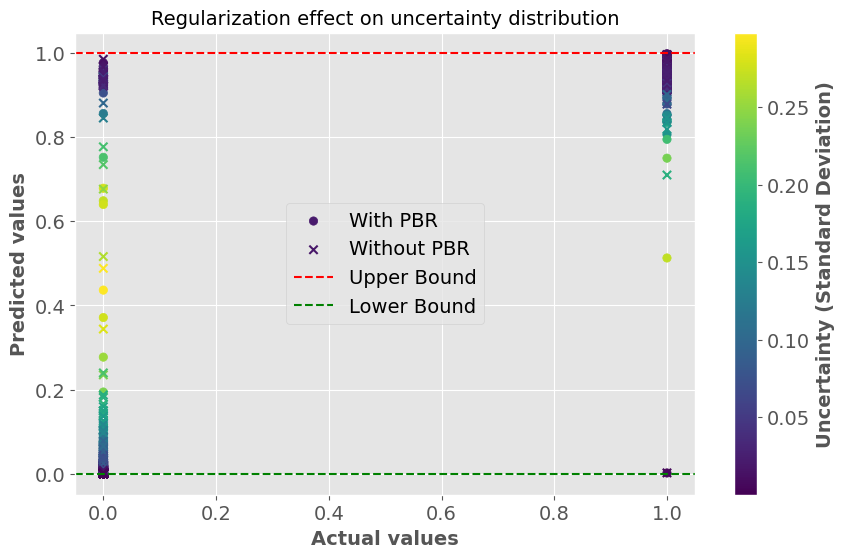

In [36]:
# Create a scatter plot of the predicted values vs. actual values for both models
plt.figure(figsize=(10, 6))
plt.scatter(y_test_scaled, y_preds.mean(axis=0), c=y_preds_std, cmap='viridis', label='With PBR')
plt.scatter(y_test_scaled, y_preds_no_reg.mean(axis=0), c=y_preds_no_reg_std, cmap='viridis', marker='x', label='Without PBR')

# Mark the constraint positions on the plot
constraint_1_position = 1.0
constraint_2_position = 0.0
plt.axhline(y=constraint_1_position, color='r', linestyle='--', label='Upper Bound')
plt.axhline(y=constraint_2_position, color='g', linestyle='--', label='Lower Bound')

plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.legend(loc = 'center')
plt.title('Regularization effect on uncertainty distribution')
plt.colorbar(label='Uncertainty (Standard Deviation)')
plt.grid(True)
plt.show()


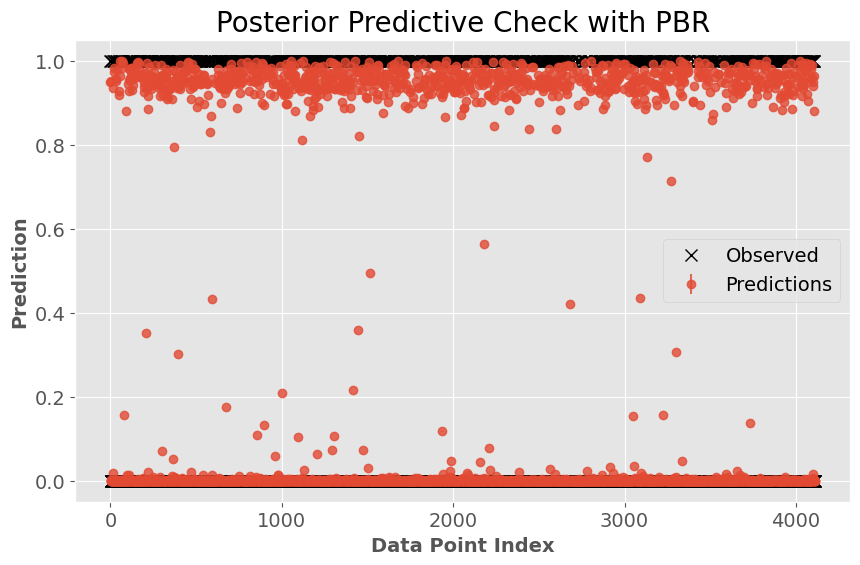

In [37]:
# Compute the mean and standard deviation of the predictions across Monte Carlo samples
y_pred_mean = np.mean(y_pred_samples, axis=0).squeeze()
y_pred_std = np.std(y_pred_samples, axis=0).squeeze()

# Plot the posterior predictive distribution along with the observed data
plt.figure(figsize=(10, 6))
plt.errorbar(range(len(y_test_scaled)), y_pred_mean, yerr=y_pred_std, fmt='o', label='Predictions', alpha=0.8)
plt.plot(range(len(y_test_scaled)), y_test_scaled, 'kx', label='Observed', markersize=8)
plt.xlabel('Data Point Index')
plt.ylabel('Prediction')
plt.title('Posterior Predictive Check with PBR', fontsize = 20)
plt.legend()
plt.show()


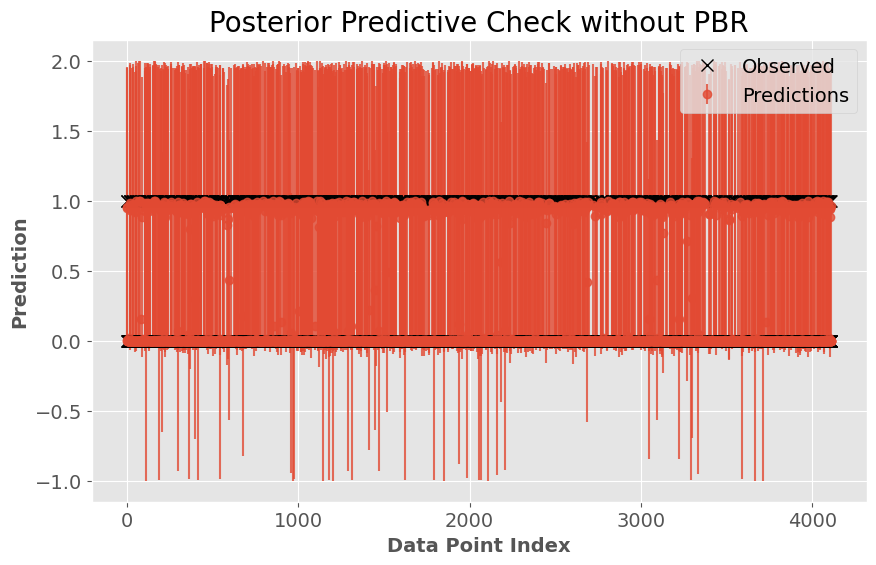

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Compute the mean and standard deviation of the predictions across Monte Carlo samples
y_pred_mean = np.mean(y_pred_samples, axis=0).squeeze()
y_pred_std = np.std(y_pred_samples, axis=0).squeeze()

# Plot the posterior predictive distribution along with the observed data
plt.figure(figsize=(10, 6))
plt.errorbar(range(len(y_test_scaled)), y_pred_mean, yerr=y_pred_bnn, fmt='o', label='Predictions', alpha=0.8)
plt.plot(range(len(y_test_scaled)), y_test_scaled, 'kx', label='Observed', markersize=8)
plt.xlabel('Data Point Index')
plt.ylabel('Prediction')
plt.title('Posterior Predictive Check without PBR', fontsize = 20)
plt.legend()
plt.show()
